In [155]:
import matplotlib.pyplot as plt
import numpy as np
import math, time
from IPython.display import clear_output

def read_stoneformations(path):
    with open(path, 'r') as f:
        stones = [d.replace('\n', '') for d in f.readlines()]
    return stones

def get_expanse(stone_lines):
    min_x = None
    max_x = None
    min_y = None
    max_y = None

    for line in stone_lines:
        for coordinate in line:
            coordinate = [int(coordinate[0]), int(coordinate[1])]
            if min_x is None or min_x > coordinate[0]:
                min_x = coordinate[0]
            if max_x is None or max_x < coordinate[0]:
                max_x = coordinate[0]
            if min_y is None or min_y > coordinate[1]:
                min_y = coordinate[1]
            if max_y is None or max_y < coordinate[1]:
                max_y = coordinate[1]
    
    return [min_x, min_y, max_x, max_y]

def draw_map(stones, with_ground):
    stone_lines = [[[500, 0]]]
    for formation in stones:
        coordinates = [vertex.split(',') for vertex in formation.split(' -> ')]
        stone_lines.append(coordinates)

    l, t, r, b = get_expanse(stone_lines)
    h = b - t + 1
    w = r - l + 1

    p0 = [500-l, 0-t]

    if with_ground:
        map = np.zeros((h+2, w))
        map[-1,:] = 0.5
    else:
        map = np.zeros((h, w))

    ### drawing stone lines ###
    for formation in stone_lines:
        p_start = [int(formation[0][0])-l, int(formation[0][1])-t]
        for i in range(1, len(formation)):
            p_end = [int(formation[i][0])-l, int(formation[i][1])-t]
            map = draw_stone_line(map, p_start, p_end)
            p_start = p_end

    ### drawing sand insertion point ###
    map[p0[1]][p0[0]] = 1.0 

    return map, p0

def draw_stone_line(map, p1, p2):
    stone_value = 0.5

    ### horizontal line ###
    if p1[1] == p2[1]:
        if p2[0] < p1[0]:
            p_temp = p1.copy()
            p1 = p2.copy()
            p2 = p_temp.copy()
        for i in range(p1[0], p2[0]+1):
            map[p1[1]][i] = stone_value

    ### vertical line ###
    elif p1[0] == p2[0]:
        if p2[1] < p1[1]:
            p_temp = p1.copy()
            p1 = p2.copy()
            p2 = p_temp.copy()
        for i in range(p1[1], p2[1]+1):
            map[i][p1[0]] = stone_value

    return map

def simulate_sand(map, p0, display_steps, with_ground):
    step = 1
    sand = 0.7
    sand_x = None
    sand_y = None


    sand_in_map = True

    while sand_in_map:
        if sand_x is None:
            sand_x = p0[0]
            sand_y = p0[1]
            map[sand_y][sand_x] = sand
        else:
            # sand dripping over bottom of map
            if sand_y+1 > map.shape[0]-1:
                map[sand_y][sand_x] = 0.0
                sand_x = None
                sand_y = None
                sand_in_map = False
                break
            # sand falls down
            elif map[sand_y+1][sand_x] == 0.0:
                map[sand_y][sand_x] = 0.0
                map[sand_y+1][sand_x] = sand
                sand_y += 1
            # sand dripping over left of map
            elif sand_x-1 < 0:
                if with_ground:
                    newcol = np.zeros((1,map.shape[0]))
                    newcol[:,-1] = 0.5
                    map = np.insert(map, 0, newcol, axis=1)
                    sand_x += 1
                    p0[0] += 1
                else:
                    map[sand_y][sand_x] = 0.0
                    sand_x = None
                    sand_y = None
                    sand_in_map = False
                    break
            # sand falling bottom left
            elif map[sand_y+1][sand_x-1] == 0.0:
                map[sand_y][sand_x] = 0.0
                map[sand_y+1][sand_x-1] = sand
                sand_y += 1
                sand_x -= 1
            # sand dripping over right of map
            elif sand_x+1 > map.shape[1]-1:
                if with_ground:
                    newcol = np.zeros((1, map.shape[0]))
                    newcol[:,-1] = 0.5
                    map = np.insert(map, map.shape[1], newcol, axis=1)
                else:
                    map[sand_y][sand_x] = 0.0
                    sand_x = None
                    sand_y = None
                    sand_in_map = False
                    break
            # sand falling bottom right
            elif map[sand_y+1][sand_x+1] == 0.0:
                map[sand_y][sand_x] = 0.0
                map[sand_y+1][sand_x+1] = sand
                sand_y += 1
                sand_x += 1
            # sand cannot move anymore
            else:
                if sand_x == p0[0] and sand_y == p0[1]:
                    break
                sand_x = None
                sand_y = None

        if map[p0[1]][p0[0]] == 0.0:
            map[p0[1]][p0[0]] = 1.0

        if step > 0 and display_steps > 0 and step%display_steps == 0:
            display(map, step)
        step += 1

    display(map, step)

    return map

def display(map, step):
    if step != 0:
        time.sleep(0.01)
        clear_output(wait=True)
    fig = plt.figure(figsize=(min(15,map.shape[1]), min(15,map.shape[0])))
    plt.imshow(map, vmin=0, vmax=1, cmap="gray")
    plt.title(f'Step {step}')
    plt.show()

def simulate(path, display_steps=0, with_ground=False):
    stones = read_stoneformations(path)
    map, p0 = draw_map(stones, with_ground)
    display(map, 0)
    map = simulate_sand(map, p0, display_steps, with_ground)
    if with_ground:
        print(f'{np.count_nonzero(map == 0.7)} amounts of sand came to rest before the sand entrance was covered.')
    else:
        print(f'{np.count_nonzero(map == 0.7)} amounts of sand came to rest before the sand started running off the map.')

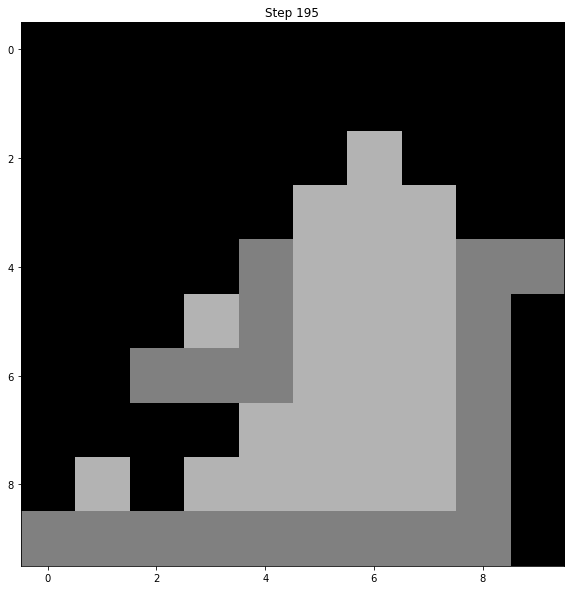

24 amounts of sand came to rest before the sand started running off the map.


In [139]:
example = "./example.txt"
test = "./test.txt"

simulate(example)

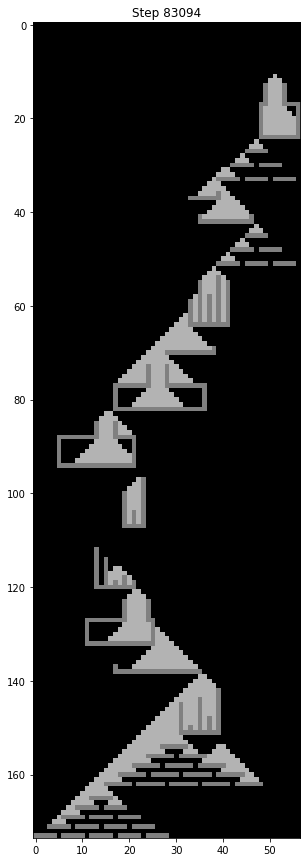

799 amounts of sand came to rest before the sand started running off the map.


In [145]:
simulate(test, display_steps=300)

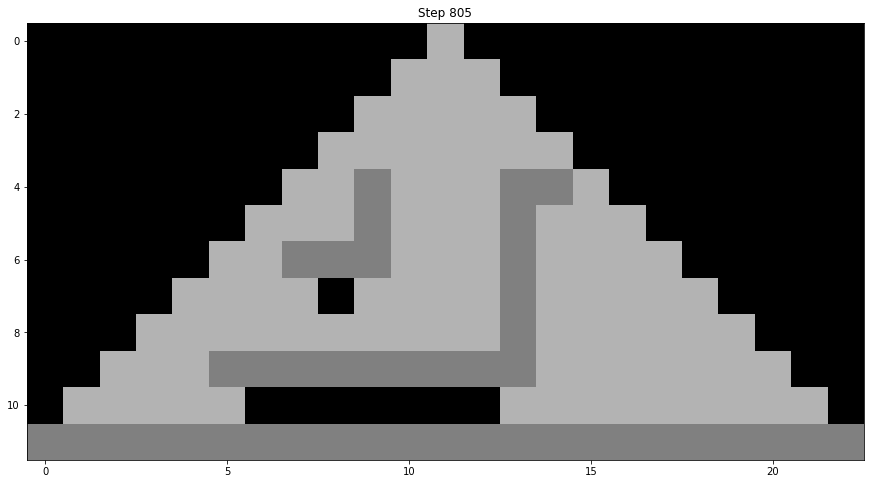

93 amounts of sand came to rest before the sand entrance was covered.


In [150]:
simulate(example, display_steps=5, with_ground=True)

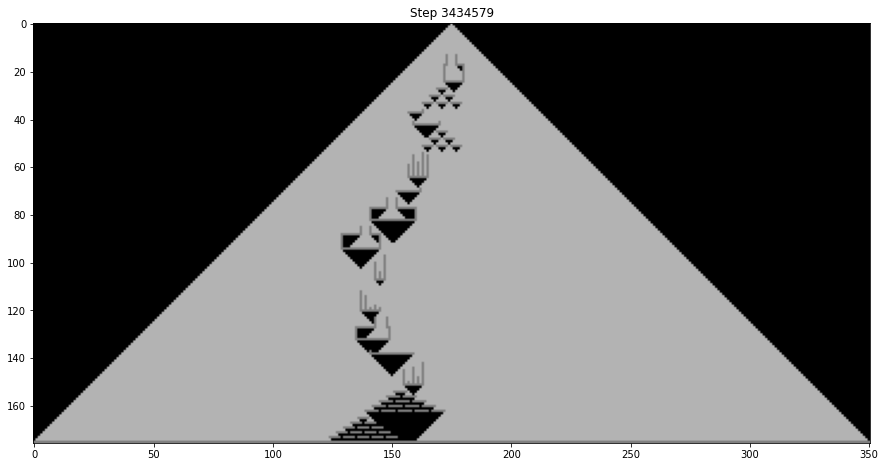

29076 amounts of sand came to rest before the sand entrance was covered.


In [156]:
simulate(test, display_steps=30000, with_ground=True)